## Computer Vision, Homework 2: Structure from Motion (SfM)
### 111061548 游鎮遠

#### 3.5 Report
##### Problems:

###### 3.1 Camera Pose from Essential Matrix (20%)

In [ ]:
'''
ESTIMATE_INITIAL_RT from the Essential Matrix, we can compute 4 initial
guesses of the relative RT between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
Returns:
    RT: A 4x3x4 tensor in which the 3x4 matrix RT[i,:,:] is one of the
        four possible transformations
'''

In [ ]:
def estimate_initial_RT(E):
    U, sigma, V_transpose = np.linalg.svd(E)            # 將 essential matrix 做 SVD 分解為 U, sigma, V_transpose

    #Z = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])    # 定義 W 矩陣

    Q1 = U.dot(W.dot(V_transpose))                      # Q1 = U W VT
    Q2 = U.dot(W.T.dot(V_transpose))                    # Q2 = U WT VT

    T1 = U[:, 2]                                        # T = u3
    T2 = -U[:, 2]                                       # T = -u3

    R1 = (np.linalg.det(Q1) * Q1).T                     # R1 = det(Q1) · Q1
    R2 = (np.linalg.det(Q2) * Q2).T                     # R2 = det(Q2) · Q2

    RT = np.array([                                     # vstack rotation (R) and translation (T)
        np.vstack([R1, T1]).T,
        np.vstack([R1, T2]).T,
        np.vstack([R2, T1]).T,
        np.vstack([R2, T2]).T
    ])

    return RT                                           # RT

estimate_initial_RT($E$)將essential matrix做SVD，可以得到$U$、$\Sigma$和$V^T$，再根據所給的$W$矩陣和$Q=U W V^T$ or $Q=U W^T V^T$得到兩個$Q$，接著以$R=det(Q) \cdot Q$就能得到兩個rotation ($R$)，再和translation ($T$)，也就是 $T=u_3$和$T=-u_3$合併得到所求的四個$RT$。

這是用來評估相機的位置，即旋轉的角度和位移。

###### 3.2 Linear 3D Points Estimation (20%)

In [ ]:
'''
LINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point is the best linear estimate
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''

In [ ]:
def linear_estimate_3d_point(image_points, camera_matrices):
    pi = image_points.copy()                            # pi = image_points
    Mi = camera_matrices.copy()                         # Mi = camera_matrices

    A1 = (pi[:, 1] * Mi[:, 2, :].T).T - Mi[:, 1, :]     # v_n M_n^3 - M_n^2
    A2 = Mi[:, 0, :] - (pi[:, 0] * Mi[:, 2, :].T).T     # M_n^1 - u_n M_n^3
    A = np.vstack([A1, A2])

    U, sigma, V_transpose = np.linalg.svd(A)            # solve P by SVD
    point_3d = V_transpose[3, :].copy()
    point_3d /= point_3d[-1]
    return point_3d[:-1]

透過$p_i$和$M_i$以外積推導$p_i \times M_i P=0$，得到
$\begin{bmatrix}
v_1{M_1}^3-{M_1}^2\\
{M_1}^1 - u_1{M_1}^3\\
.\\.\\.\\
v_n{M_n}^3-{M_n}^2\\
{M_n}^1 - u_n{M_n}^3\\
\end{bmatrix} \cdot P=0$
，

再對其左邊的矩陣做SVC解$P$得到$U$、$\Sigma$和$V^T$，將$V^T$的最後一個row除以$V^T$的最後一個row的最後一個數即為3D點的位置。


###### 3.3 Non-Linear 3D Points Estimation (20%)

In [ ]:
'''
JACOBIAN given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    jacobian - the 2Mx3 Jacobian matrix
'''

In [ ]:
def jacobian(point_3d, camera_matrices):
    P = np.hstack([point_3d.copy(), 1])                 # P = [point_3d\\ 1]
    Mi = camera_matrices.copy()                         # Mi = camera_matrices

    numerator = (np.matmul(Mi[:, 2, :], P)) ** 2        # jacobian 所有偏微分的共同分母

    Jx1 = Mi[:, 0, 0] * np.matmul(Mi[:, 2, [1, 2, 3]], P[[1, 2, 3]]) - Mi[:, 2, 0] * \
        np.matmul(Mi[:, 0, [1, 2, 3]], P[[1, 2, 3]])       
    # jacobian 所有偏微分中每一個 partial X 元素的第一項
    Jx2 = Mi[:, 0, 1] * np.matmul(Mi[:, 2, [0, 2, 3]], P[[0, 2, 3]]) - Mi[:, 2, 1] * \
        np.matmul(Mi[:, 0, [0, 2, 3]], P[[0, 2, 3]])       
    # jacobian 所有偏微分中每一個 partial Y 元素的第一項
    Jx3 = Mi[:, 0, 2] * np.matmul(Mi[:, 2, [0, 1, 3]], P[[0, 1, 3]]) - Mi[:, 2, 2] * \
        np.matmul(Mi[:, 0, [0, 1, 3]], P[[0, 1, 3]])       
    # jacobian 所有偏微分中每一個 partial Z 元素的第一項

    Jy1 = Mi[:, 1, 0] * np.matmul(Mi[:, 2, [1, 2, 3]], P[[1, 2, 3]]) - Mi[:, 2, 0] * \
        np.matmul(Mi[:, 1, [1, 2, 3]], P[[1, 2, 3]])       
    # jacobian 所有偏微分中每一個 partial X 元素的第二項
    Jy2 = Mi[:, 1, 1] * np.matmul(Mi[:, 2, [0, 2, 3]], P[[0, 2, 3]]) - Mi[:, 2, 1] * \
        np.matmul(Mi[:, 1, [0, 2, 3]], P[[0, 2, 3]])       
    # jacobian 所有偏微分中每一個 partial Y 元素的第二項
    Jy3 = Mi[:, 1, 2] * np.matmul(Mi[:, 2, [0, 1, 3]], P[[0, 1, 3]]) - Mi[:, 2, 2] * \
        np.matmul(Mi[:, 1, [0, 1, 3]], P[[0, 1, 3]])       
    # jacobian 所有偏微分中每一個 partial Z 元素的第二項

    Jx = np.vstack([[Jx1], [Jx2], [Jx3]])               # 組合 jacobian 所有偏微分的第一項
    Jy = np.vstack([[Jy1], [Jy2], [Jy3]])               # 組合 jacobian 所有偏微分的第二項
    Jx = np.divide(Jx, numerator).T                     # 同除共同分母
    Jy = np.divide(Jy, numerator).T                     # 同除共同分母

    jacobian = np.zeros((2 * Jx.shape[0], Jy.shape[1])) # 組合 jacobian 矩陣
    jacobian[0::2, :] = Jx
    jacobian[1::2, :] = Jy

    return jacobian

為獲得jacobian矩陣，需先推導jacobian中所有偏微分元素的組合順序，以$\frac{\partial e_i}{\partial X_i}$為例，$$\frac{\partial e_i}{\partial X_i} = \frac{\partial e_i}{\partial p_i^\prime}\times \frac{\partial p_i^\prime}{\partial X_i} = \frac{\partial (p_i^\prime - p_i)}{\partial p_i^\prime}\times\frac{\partial p_i^\prime}{\partial X_i} = 1 \times \frac{\partial p_i^\prime}{\partial X_i}$$
也就是$\frac{\partial e_i}{\partial X_i}$其實等於$\frac{\partial p_i^\prime}{\partial X_i}$，$$J = \begin{bmatrix}
\frac{\partial p_1^\prime}{\partial X_1} & \frac{\partial p_1^\prime}{\partial Y_1} & \frac{\partial p_1^\prime}{\partial Z_1}\\.\\.\\.\\
\frac{\partial p_{2n}^\prime}{\partial X_n} & \frac{\partial p_{2n}^\prime}{\partial Y_n} & \frac{\partial p_{2n}^\prime}{\partial Z_n}\\
\end{bmatrix}$$

接著計算$\frac{\partial p_i^\prime}{\partial X_i}$，
$M_i=\begin{bmatrix}
{m_i}_{00}&{m_i}_{01}&{m_i}_{02}&{m_i}_{03}\\
{m_i}_{10}&{m_i}_{11}&{m_i}_{12}&{m_i}_{13}\\
{m_i}_{20}&{m_i}_{21}&{m_i}_{22}&{m_i}_{23}
\end{bmatrix}$，
$P=\begin{bmatrix}X\\Y\\Z\\1
\end{bmatrix}$

以公式得知$$y_i = M_i P=\begin{bmatrix}
{m_i}_{00}&{m_i}_{01}&{m_i}_{02}&{m_i}_{03}\\
{m_i}_{10}&{m_i}_{11}&{m_i}_{12}&{m_i}_{13}\\
{m_i}_{20}&{m_i}_{21}&{m_i}_{22}&{m_i}_{23}
\end{bmatrix} \times \begin{bmatrix}X\\Y\\Z\\1
\end{bmatrix} = \begin{bmatrix}
{m_i}_{00}X+{m_i}_{01}Y+{m_i}_{02}Z+{m_i}_{03}\\
{m_i}_{10}X+{m_i}_{11}Y+{m_i}_{12}Z+{m_i}_{13}\\
{m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23}
\end{bmatrix}$$
再以公式得知
$$p_i^\prime=\frac{1}{{y_i}_3}\begin{bmatrix}{y_i}_1\\{y_i}_2\end{bmatrix} = \begin{bmatrix}
\frac{{m_i}_{00}X+{m_i}_{01}Y+{m_i}_{02}Z+{m_i}_{03}}{{m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23}}\\
\frac{{m_i}_{10}X+{m_i}_{11}Y+{m_i}_{12}Z+{m_i}_{13}}{{m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23}}
\end{bmatrix}$$
所以
$$\frac{\partial p_i^\prime}{\partial X}=\begin{bmatrix}
\frac{{m_i}_{00}({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})-{m_i}_{20}({m_i}_{00}X+{m_i}_{01}Y+{m_i}_{02}Z+{m_i}_{03})}{({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})^2}\\
\frac{{m_i}_{10}({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})-{m_i}_{20}({m_i}_{10}X+{m_i}_{11}Y+{m_i}_{12}Z+{m_i}_{13})}{({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})^2}
\end{bmatrix}$$
$$\frac{\partial p_i^\prime}{\partial Y}=\begin{bmatrix}
\frac{{m_i}_{01}({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})-{m_i}_{21}({m_i}_{00}X+{m_i}_{01}Y+{m_i}_{02}Z+{m_i}_{03})}{({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})^2}\\
\frac{{m_i}_{11}({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})-{m_i}_{21}({m_i}_{10}X+{m_i}_{11}Y+{m_i}_{12}Z+{m_i}_{13})}{({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})^2}
\end{bmatrix}$$
$$\frac{\partial p_i^\prime}{\partial Z}=\begin{bmatrix}
\frac{{m_i}_{02}({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})-{m_i}_{22}({m_i}_{00}X+{m_i}_{01}Y+{m_i}_{02}Z+{m_i}_{03})}{({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})^2}\\
\frac{{m_i}_{12}({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})-{m_i}_{22}({m_i}_{10}X+{m_i}_{11}Y+{m_i}_{12}Z+{m_i}_{13})}{({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})^2}
\end{bmatrix}$$
$({m_i}_{20}X+{m_i}_{21}Y+{m_i}_{22}Z+{m_i}_{23})^2$即為共同分母，將此些算式組合，即為jacobian ($J$)。



In [ ]:
'''
REPROJECTION_ERROR given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    error - the 2M reprojection error vector
'''

In [ ]:
def reprojection_error(point_3d, image_points, camera_matrices):
    pi = image_points.copy()                            # pi = image_points
    Mi = camera_matrices.copy()                         # Mi = camera_matrices
    P = np.hstack([point_3d.copy(), 1])                 # P = [point_3d\\ 1]

    y = np.matmul(Mi, P)                                # y = M_i P
    y = y.T
    pi_prime = y / y[-1, :]                             # pi_prime = 1/y_3 [y_1\\ y_2]

    ei = (pi_prime[:-1, :].T - pi).reshape(2 * pi.shape[0], )       # ei = pi_prime - pi
    return ei

根據公式$y=M_i P$計算出每個$y_i$，再以$p_i^\prime = \frac{1}{{y_i}_3} \begin{bmatrix}{{y_i}_1}\\{{y_i}_2} \end{bmatrix}$計算出$p_i^\prime$，最後$e_i=p_i^\prime - p_i$。

In [ ]:
'''
NONLINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point that iteratively updates the points
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''

In [ ]:
def nonlinear_estimate_3d_point(image_points, camera_matrices):
    pi = image_points.copy()                            # pi = image_points
    Mi = camera_matrices.copy()                         # Mi = camera_matrices

    iterations = 10                                     # run the optimization for 10 iterations

    estimated_3d_point = linear_estimate_3d_point(pi, Mi)                                                                       
    # linear_estimate_3d_point()

    for i in range(iterations):
        J = jacobian(estimated_3d_point, Mi)                                                                                    
        # jacobian()
        reprojection_error_ = reprojection_error(estimated_3d_point, pi, Mi)                                                    
        # reprojection error()
        estimated_3d_point = estimated_3d_point - \
            np.matmul(np.matmul(np.linalg.inv(J.T.dot(J)), J.T), reprojection_error_)     
        # P = P - (J^T J)^-1 J^T e

    return estimated_3d_point

先以linear_estimate_3d_point(pi, Mi)作為$P$的initial guess，再以公式$P = P-(J^T J)^{-1} J^T e$ 迭代10次。

###### 3.4 Decide the Correct RT (20%)

In [ ]:
'''
ESTIMATE_RT_FROM_E from the Essential Matrix, we can compute  the relative RT 
between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
    image_points - N measured points in each of the M images (NxMx2 matrix)
    K - the intrinsic camera matrix
Returns:
    RT: The 3x4 matrix which gives the rotation and translation between the 
        two cameras
'''

In [ ]:
def estimate_RT_from_E(E, image_points, K):
    estimate_initial_RT_ = estimate_initial_RT(E)       # 呼叫四種可能的 RT

    correct_RT_temp = [0, 0, 0, 0]                      # 建立投票矩陣

    M1 = K.dot(np.append(np.eye(3), np.zeros((3, 1)), axis=1))      # 第一個相機的相機矩陣

    for i in range(image_points.shape[0]):
        for j in range(estimate_initial_RT_.shape[0]):
            M2 = K.dot(estimate_initial_RT_[j])                     # 透過四種 RT 轉換的第二個相機的相機矩陣
            M = np.array((M1, M2))                                  # 合併兩種相機矩陣

            X = linear_estimate_3d_point(image_points[i], M)        # 估計第一個3D點
            X2 = estimate_initial_RT_[j].dot(np.append(X, 1).T)     # 透過四種 RT 轉換的第二個3D點

            if X2[2] > 0 and X[2] > 0:                              # 檢查兩個3D點的Z軸是否都為正
                correct_RT_temp[j] += 1                             # 在四種 RT 的投票矩陣投票

    RT = estimate_initial_RT_[np.argmax(correct_RT_temp)]           # 得到真正的RT

    return RT

先呼叫estimate_initial_RT(E)得到四種可能的RT，並建立一個針對各RT的投票矩陣，透過四種RT的轉換，得到真正的RT。

#### 3.5 Result

In [ ]:
--------------------------------------------------------------------------------
Part A: Check your matrices against the example R,T
--------------------------------------------------------------------------------
Example RT:
 [[ 0.9736 -0.0988 -0.2056  0.9994]
  [ 0.1019  0.9948  0.0045 -0.0089]
  [ 0.2041 -0.0254  0.9786  0.0331]]

Estimated RT:
 [[[ 0.98305251 -0.11787055 -0.14040758  0.99941228]
  [-0.11925737 -0.99286228 -0.00147453 -0.00886961]
  [-0.13923158  0.01819418 -0.99009269  0.03311219]]

 [[ 0.98305251 -0.11787055 -0.14040758 -0.99941228]
  [-0.11925737 -0.99286228 -0.00147453  0.00886961]
  [-0.13923158  0.01819418 -0.99009269 -0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
  [ 0.10189204  0.99478508  0.00454512 -0.00886961]
  [ 0.2040601  -0.02537241  0.97862951  0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119 -0.99941228]
  [ 0.10189204  0.99478508  0.00454512  0.00886961]
  [ 0.2040601  -0.02537241  0.97862951 -0.03311219]]]
--------------------------------------------------------------------------------
Part B: Check that the difference from expected point 
is near zero
--------------------------------------------------------------------------------
Difference:  0.0029243053036762667
--------------------------------------------------------------------------------
Part C: Check that the difference from expected error/Jacobian 
is near zero
--------------------------------------------------------------------------------
Error Difference:  8.301300414891369e-07
Jacobian Difference:  1.8171196103367038e-08
--------------------------------------------------------------------------------
Part D: Check that the reprojection error from nonlinear method
is lower than linear method
--------------------------------------------------------------------------------
Linear method error: 98.73542356894183
Nonlinear method error: 95.59481784846034
--------------------------------------------------------------------------------
Part E: Check your matrix against the example R,T
--------------------------------------------------------------------------------
Example RT:
 [[ 0.9736 -0.0988 -0.2056  0.9994]
 [ 0.1019  0.9948  0.0045 -0.0089]
 [ 0.2041 -0.0254  0.9786  0.0331]]

Estimated RT:
 [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
 [ 0.10189204  0.99478508  0.00454512 -0.00886961]
 [ 0.2040601  -0.02537241  0.97862951  0.03311219]]
--------------------------------------------------------------------------------
Part F: Run the entire SFM pipeline
--------------------------------------------------------------------------------
Save results to results.npy!

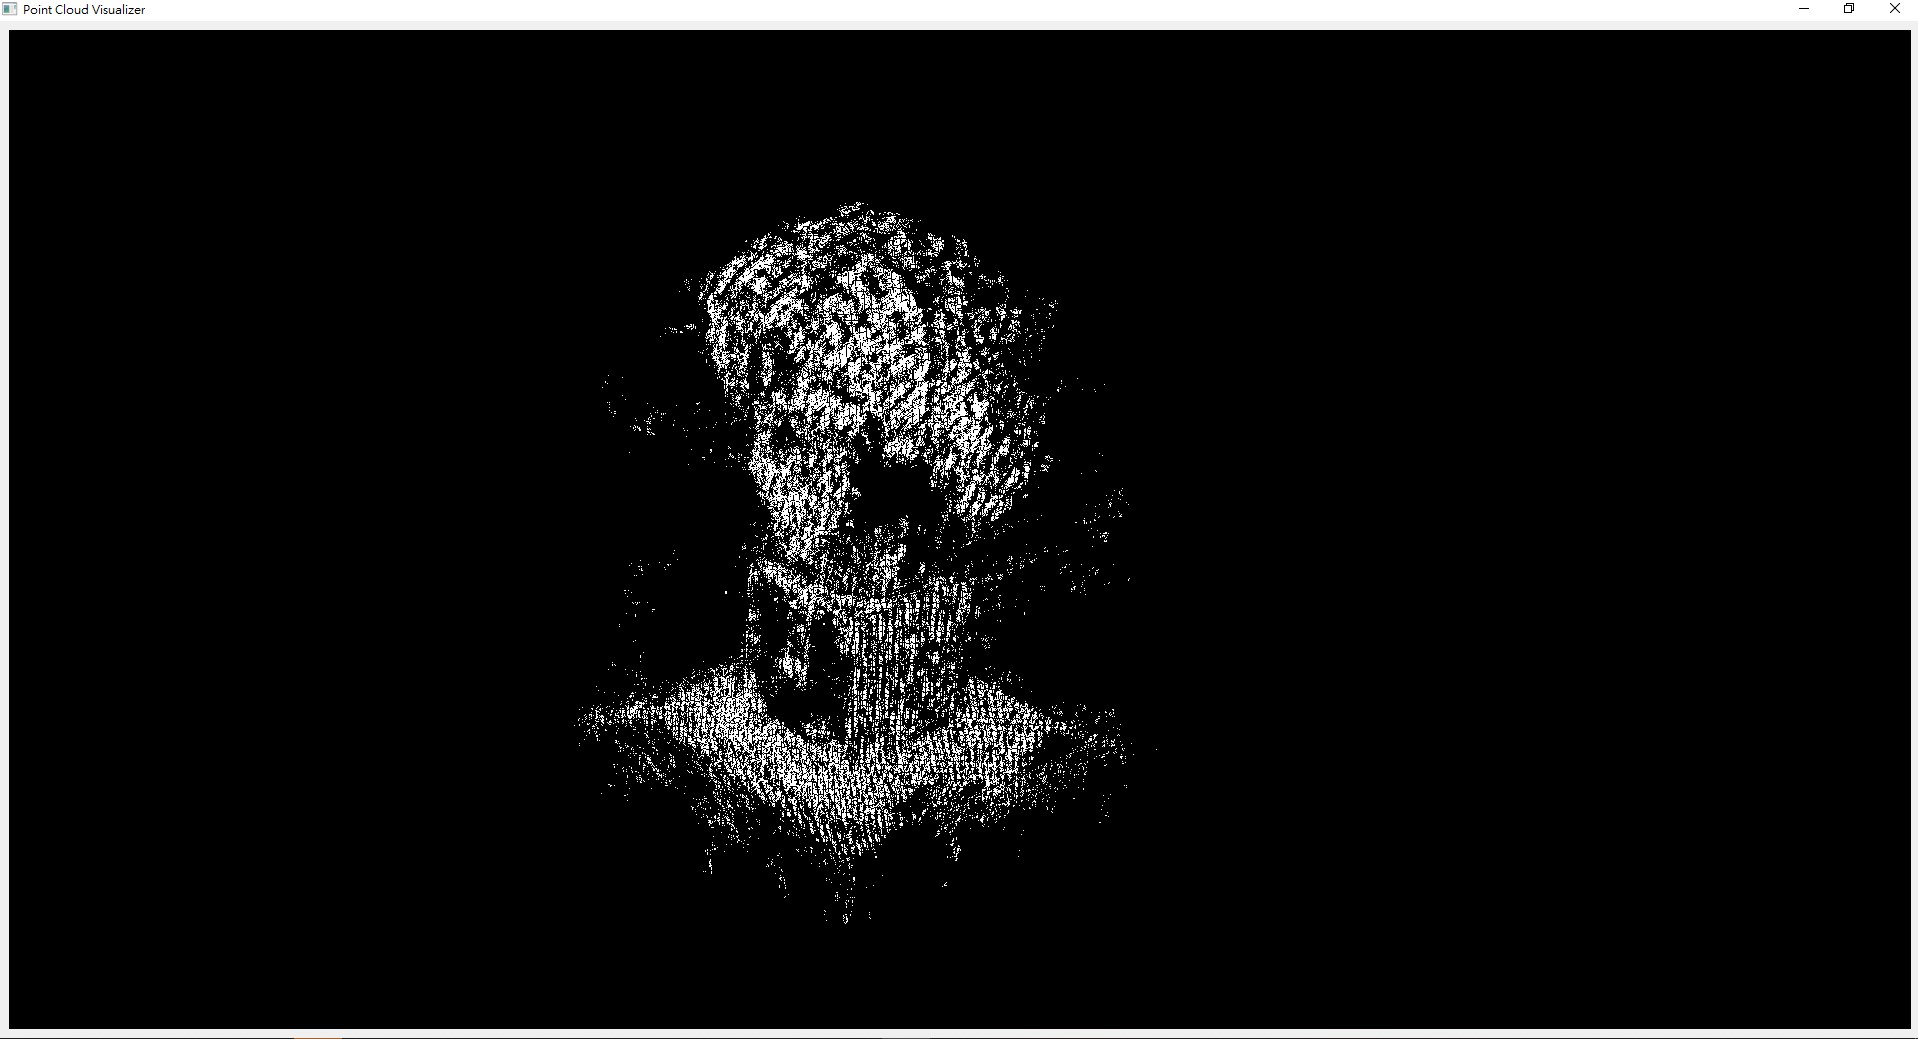

#### 心得:
    相較於上次的作業，這次的作業可以說是難上許多，但其主題也很有趣，就像自己在建造一個3D掃描儀一樣，且經過這次的作業，也讓我對於相機的成像、translation和Rotation之類的原理更加了解。